# Parcial: Construcción e implementación de , Random Forest 

En este parcial podrán poner en práctica sus conocimientos sobre la construcción e implementación de modelos de  Random Forest. El taller está constituido por 8 puntos, en los cuales deberan seguir las intrucciones de cada numeral para su desarrollo.

## Datos predicción precio de automóviles

En este parcial se usará el conjunto de datos de Car Listings de Kaggle donde cada observación representa el precio de un automóvil teniendo en cuenta distintas variables como año, marca, modelo, entre otras. El objetivo es predecir el precio del automóvil. Para más detalles puede visitar el siguiente enlace: [datos](https://www.kaggle.com/jpayne/852k-used-car-listings).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
#librerias
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


In [3]:
# Importación de librerías
%matplotlib inline
import pandas as pd

# Lectura de la información de archivo .csv
data = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/dataTrain_carListings.zip')

# Preprocesamiento de datos para el taller
data = data.loc[data['Model'].str.contains('Camry')].drop(['Make', 'State'], axis=1)
data = data.join(pd.get_dummies(data['Model'], prefix='M'))
data = data.drop(['Model'], axis=1)

# Visualización dataset
data.head()

,Price,Year,Mileage,M_Camry,M_Camry4dr,M_CamryBase,M_CamryL,M_CamryLE,M_CamrySE,M_CamryXLE
7,21995,2014,6480,False,False,False,True,False,False,False
11,13995,2014,39972,False,False,False,False,True,False,False
167,17941,2016,18989,False,False,False,False,False,True,False
225,12493,2014,51330,False,False,False,True,False,False,False
270,7994,2007,116065,False,True,False,False,False,False,False


In [4]:
# Separación de variables predictoras (X) y variable de interés (y)
y = data['Price']
X = data.drop(['Price'], axis=1)



In [5]:
# Separación de datos en set de entrenamiento y test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Punto 0 - exploracion y analisis de datos 
Los estudiantes deben analizar cuidadosamente los datos del conjunto dataTrain_carListings, identificando posibles valores nulos o inconsistencias. En caso de encontrar datos faltantes, deberán aplicar técnicas de imputación adecuadas para completar la información de manera coherente. Posteriormente, se espera que realicen una exploración visual mediante gráficos que permitan comprender la distribución y las relaciones entre las variables principales.

<class 'pandas.core.frame.DataFrame'>
Index: 10495 entries, 7 to 399976
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Price        10495 non-null  int64
 1   Year         10495 non-null  int64
 2   Mileage      10495 non-null  int64
 3   M_Camry      10495 non-null  bool 
 4   M_Camry4dr   10495 non-null  bool 
 5   M_CamryBase  10495 non-null  bool 
 6   M_CamryL     10495 non-null  bool 
 7   M_CamryLE    10495 non-null  bool 
 8   M_CamrySE    10495 non-null  bool 
 9   M_CamryXLE   10495 non-null  bool 
dtypes: bool(7), int64(3)
memory usage: 399.7 KB
None

               Price          Year        Mileage
count  10495.000000  10495.000000   10495.000000
mean   14538.403716   2013.553883   52509.430395
std     3922.420961      3.116585   36791.736601
min     5002.000000   1998.000000       5.000000
25%    11999.000000   2012.000000   26461.000000
50%    15000.000000   2014.000000   41680.000000
75%    16999.000

Text(0.5, 1.0, 'Distribución del kilometraje')

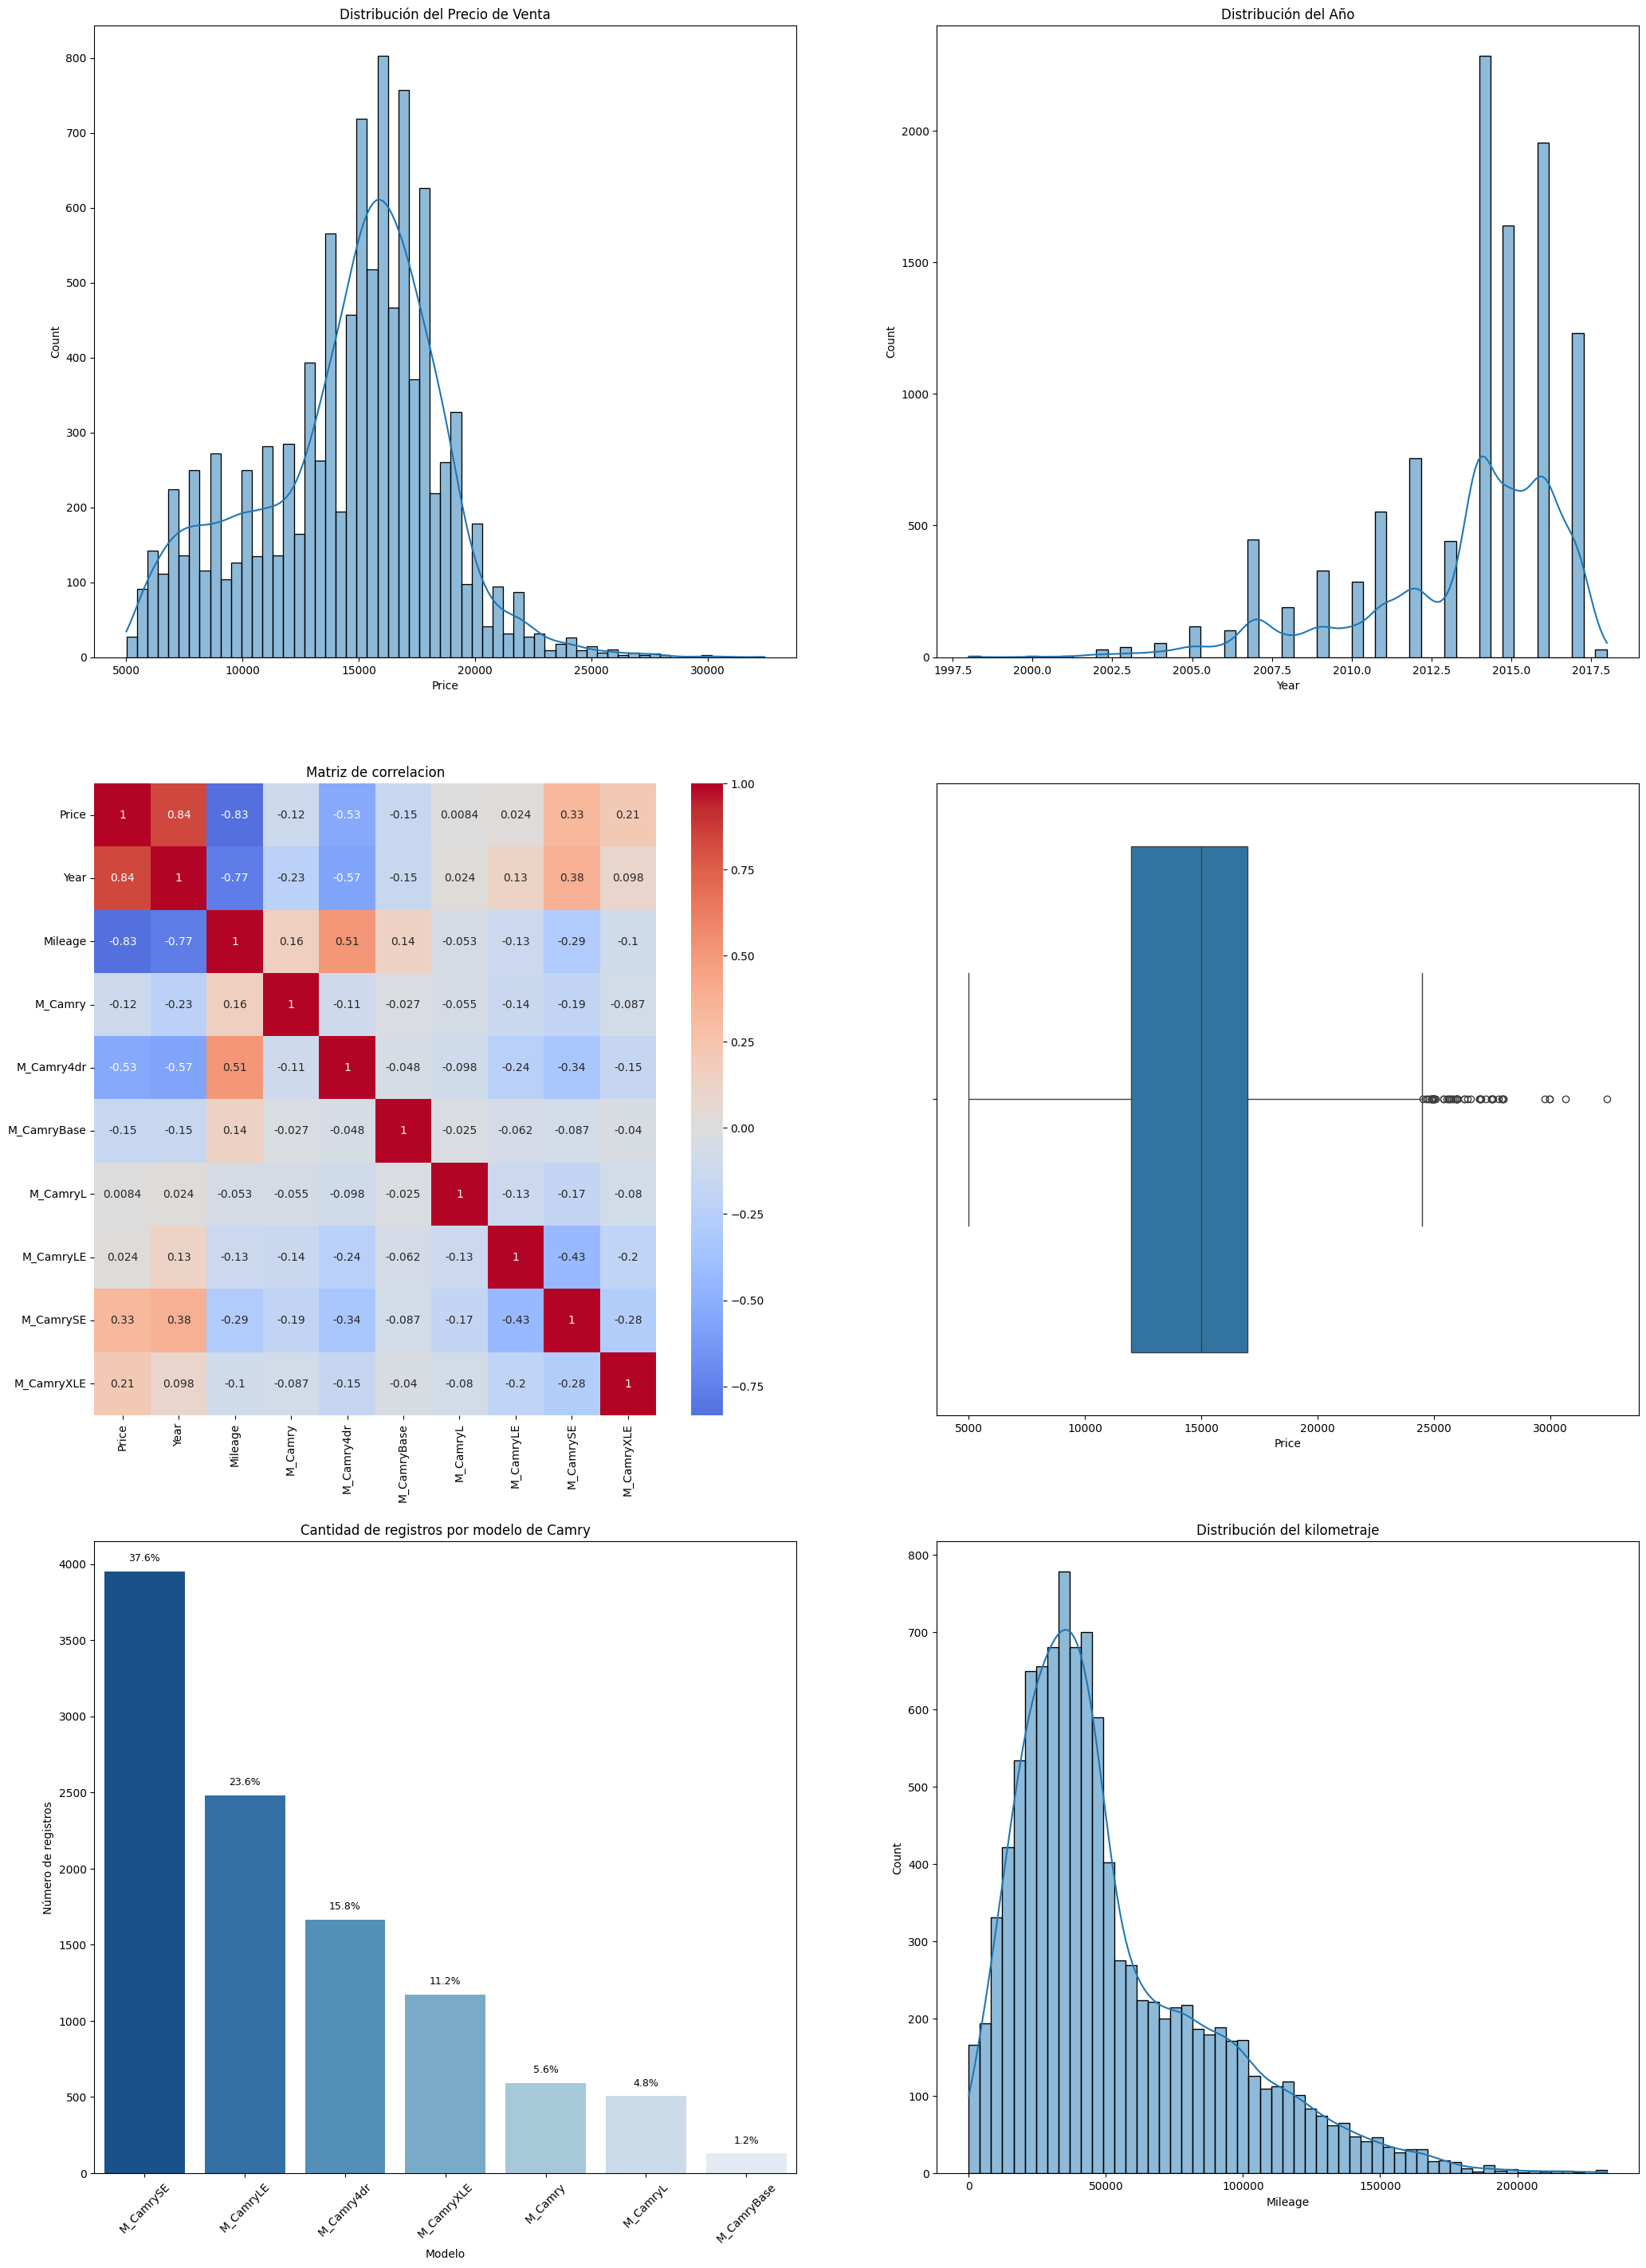

In [6]:
# celda 0 - exploracion y analisis de datos
print(data.info())
print('\n',data.describe())
print('\nTamaño del dataset',data.shape)
print('\n',data.isnull().sum().sort_values(ascending=False).head(20))
print((data == 0).sum())
cv = (data['Price'].std() / data['Price'].mean()) * 100

for col in ['Price', 'Mileage', 'Year']:
    cv = (data[col].std() / data[col].mean()) * 100
    print(f"{col}: {cv:.2f}%")




fig,axes = plt.subplots(3,2, figsize=(25,35))
sns.histplot(data['Price'], kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribución del Precio de Venta')

sns.histplot(data['Year'], kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribución del Año')

corr = data.corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', center=0, ax=axes[1,0])
axes [1,0].set_title('Matriz de correlacion')

sns.boxplot(x=data['Price'], ax=axes[1,1])





# Filtramos las columnas que empiezan por "M_Camry"
camry_cols = [col for col in data.columns if col.startswith('M_Camry')]

# Contamos cuántos True (1) hay en cada variable
category_counts = data[camry_cols].sum().sort_values(ascending=False)

# Graficamos en la posición especificada
sns.barplot(x=category_counts.index, y=category_counts.values, palette='Blues_r', ax=axes[2,0])
axes[2,0].set_title('Cantidad de registros por modelo de Camry')
axes[2,0].set_xlabel('Modelo')
axes[2,0].set_ylabel('Número de registros')
axes[2,0].tick_params(axis='x', rotation=45)

# Añadimos porcentajes sobre las barras
total = len(data)
for i, v in enumerate(category_counts.values):
    axes[2,0].text(i, v + (total * 0.005), f'{(v/total)*100:.1f}%', ha='center', va='bottom', fontsize=9)




sns.histplot(data['Mileage'], kde=True, ax=axes[2,1])
axes[2,1].set_title('Distribución del kilometraje')





### Dispersion de Mileage

Debido a la alta dispersión de mileage se decide utilizar una transformación logarítmica con la finalidad de reducir su escala, suavizar la dispersión y disminuir la influencia de datos atipicos.

CV original de Mileage: 70.07%
CV transformado (log) : 8.42%
count    10495.000000
mean        10.589657
std          0.892025
min          1.791759
25%         10.183465
50%         10.637801
75%         11.175444
max         12.357329
Name: Mileage_log, dtype: float64
Coeficiente de variación del precio: 8.42%


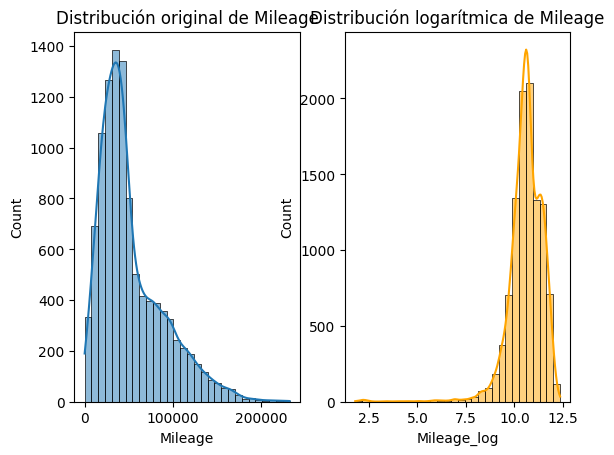

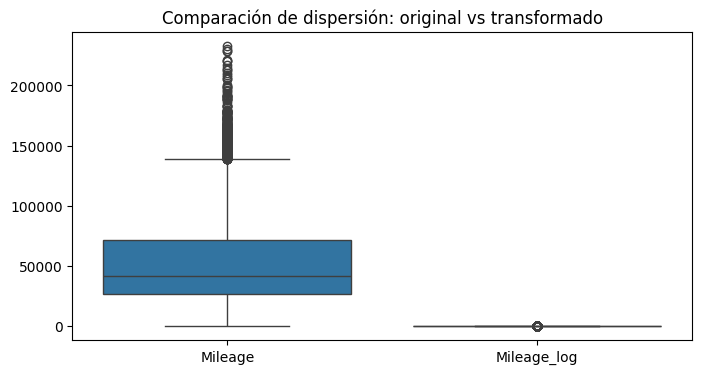

Coeficiente de variacion de variables booleanas
M_Camry: media=0.0563, std=0.2305, CV=409.39%
M_Camry4dr: media=0.1585, std=0.3652, CV=230.46%
M_CamryBase: media=0.0123, std=0.1102, CV=896.46%
M_CamryL: media=0.0482, std=0.2142, CV=444.33%
M_CamryLE: media=0.2365, std=0.4249, CV=179.69%
M_CamrySE: media=0.3764, std=0.4845, CV=128.73%
M_CamryXLE: media=0.1119, std=0.3152, CV=281.79%


In [48]:
data['Mileage_log'] = np.log1p(data['Mileage'])
cv_original = (data['Mileage'].std() / data['Mileage'].mean()) * 100
cv_log = (data['Mileage_log'].std() / data['Mileage_log'].mean()) * 100

print(f"CV original de Mileage: {cv_original:.2f}%")
print(f"CV transformado (log) : {cv_log:.2f}%")

print(data['Mileage_log'].describe())

cv = (data['Mileage_log'].std() / data['Mileage_log'].mean()) * 100
print(f"Coeficiente de variación del precio: {cv:.2f}%")


plt.subplot(1, 2, 1)
sns.histplot(data['Mileage'], bins=30, kde=True)
plt.title('Distribución original de Mileage')

plt.subplot(1, 2, 2)
sns.histplot(data['Mileage_log'], bins=30, kde=True, color='orange')
plt.title('Distribución logarítmica de Mileage')

plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(data=data[['Mileage','Mileage_log']])
plt.title('Comparación de dispersión: original vs transformado')
plt.show()

bool_cols = data.select_dtypes(include=['bool']).columns



print("Coeficiente de variacion de variables booleanas")
for col in bool_cols:
    mean = data[col].mean()
    std = data[col].std()
    cv = (std / mean * 100) if mean != 0 else 0
    print(f"{col}: media={mean:.4f}, std={std:.4f}, CV={cv:.2f}%")



### Punto 1 - Random forest con librería

En la celda 1, usando la librería sklearn entrenen un modelo de Randon Forest para regresion  y comenten sobre el desempeño del modelo.

In [52]:
# Celda 1


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



X = data[['Year', 'Mileage_log', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']]
y = data['Price']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf_model = RandomForestRegressor(
    n_estimators=100,   
    random_state=42,
    n_jobs=-1           
)


rf_model.fit(X_train, y_train)


y_pred = rf_model.predict(X_test)


rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}")


RMSE: 1,816.11
MAE : 1,341.10
R²  : 0.7824


Primer modelo sin hiperparametros eficientes: puntuacion de 0.73 r2, se puede mejorar al encontrar los mejores hiperparametros

### Punto 2 - Calibración de parámetros Random forest

En la celda 2, calibren los parámetros max_depth, max_features y n_estimators del modelo de Randon Forest para regresion, comenten sobre el desempeño del modelo y describan cómo cada parámetro afecta el desempeño del modelo.

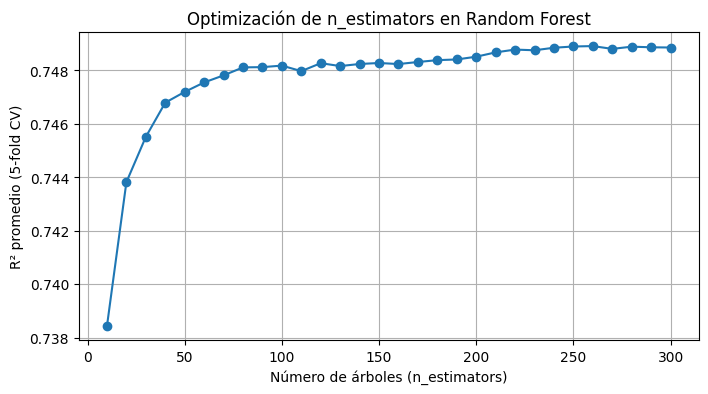

Mejor n_estimators: 260 con R² promedio de 0.7489


In [50]:
# Celda 2


from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score


estimator_range = range(10, 310, 10)


r2_scores = []

for estimator in estimator_range:
    
    rf = RandomForestRegressor(
        n_estimators=estimator,
        random_state=42,
        n_jobs=-1,
        max_depth=None
    )
    
   
    scores = cross_val_score(rf, X, y, cv=5, scoring='r2')
    r2_scores.append(scores.mean())


plt.figure(figsize=(8,4))
plt.plot(estimator_range, r2_scores, marker='o')
plt.xlabel('Número de árboles (n_estimators)')
plt.ylabel('R² promedio (5-fold CV)')
plt.title('Optimización de n_estimators en Random Forest')
plt.grid(True)
plt.show()


best_n = estimator_range[np.argmax(r2_scores)]
best_r2 = max(r2_scores)
print(f"Mejor n_estimators: {best_n} con R² promedio de {best_r2:.4f}")






Mejor profundidad: {'max_depth': 8}
Mejor R²: 0.8495242520019106


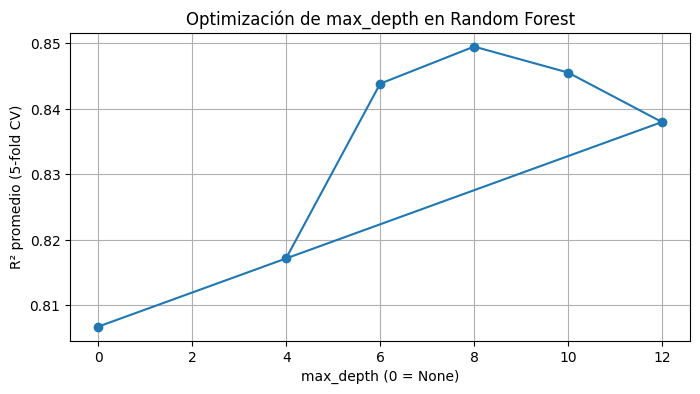

Mejor max_depth: 8 con R² promedio de 0.8495


In [43]:
from sklearn.model_selection import GridSearchCV

rf_model = RandomForestRegressor(n_estimators=260, random_state=42, n_jobs=-1)


param_grid = {
    'max_depth': [4, 6, 8, 10, 12, None]
}

grid = GridSearchCV(rf_model, param_grid, cv=5, scoring='r2')
grid.fit(X_train, y_train)

print("Mejor profundidad:", grid.best_params_)
print("Mejor R²:", grid.best_score_)

results = grid.cv_results_
depths = [d if d is not None else 0 for d in results['param_max_depth']]
scores = results['mean_test_score']

plt.figure(figsize=(8,4))
plt.plot(depths, scores, marker='o')
plt.xlabel('max_depth (0 = None)')
plt.ylabel('R² promedio (5-fold CV)')
plt.title('Optimización de max_depth en Random Forest')
plt.grid(True)
plt.show()


best_depth = grid.best_params_['max_depth']
best_r2 = grid.best_score_
print(f"Mejor max_depth: {best_depth} con R² promedio de {best_r2:.4f}")

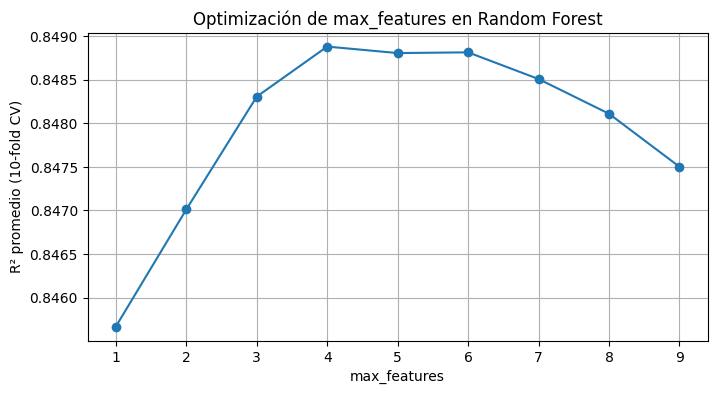

Mejor max_features: 4 con R² promedio de 0.8489


In [53]:

feature_cols = X.columns


feature_range = range(1, len(feature_cols) + 1)


r2_scores = []

for feature in feature_range:
    rf = RandomForestRegressor(
        n_estimators=260,
        max_features=feature,
        random_state=42,
        max_depth=8,
        n_jobs=-1
    )
    
    
    scores = cross_val_score(rf, X, y, cv=10, scoring='r2')
    r2_scores.append(scores.mean())


plt.figure(figsize=(8,4))
plt.plot(feature_range, r2_scores, marker='o')
plt.xlabel('max_features')
plt.ylabel('R² promedio (10-fold CV)')
plt.title('Optimización de max_features en Random Forest')
plt.grid(True)
plt.show()


best_f = feature_range[np.argmax(r2_scores)]
best_r2 = max(r2_scores)
print(f"Mejor max_features: {best_f} con R² promedio de {best_r2:.4f}")




Mejor max_feature utilizando el mejor n_estimators y max_depth

In [54]:
rf_final = RandomForestRegressor(
    n_estimators=260,
    max_features=best_f,
    random_state=42,
    max_depth=None,
    n_jobs=-1
)

rf_final.fit(X, y)

importances = rf_final.feature_importances_

df_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values('Importance', ascending=False)

print(df_importances)



       Feature  Importance
0         Year    0.466144
1  Mileage_log    0.454879
3   M_Camry4dr    0.033584
8   M_CamryXLE    0.014714
7    M_CamrySE    0.013320
6    M_CamryLE    0.008505
2      M_Camry    0.005623
5     M_CamryL    0.001891
4  M_CamryBase    0.001341


4 es el mejor valor de max_features que se adapta en el modelo dando el tercer hiperparametro mejorado

Es clave el uso de todas las columnas para obtener un mayor promedio

Resultados del modelo completamente optimizado:
RMSE: 1,587.24
MAE : 1,151.77
R²  : 0.8338


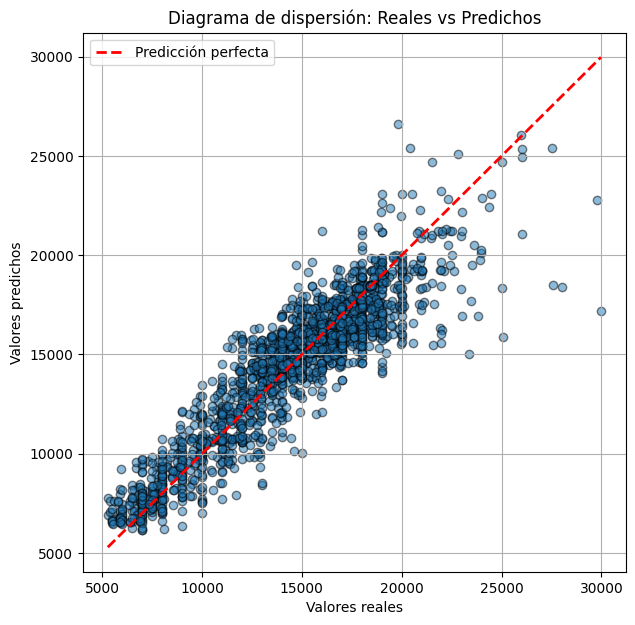

In [ ]:
X = data[['Year', 'Mileage_log', 'M_Camry', 'M_Camry4dr', 'M_CamryBase', 'M_CamryL', 'M_CamryLE', 'M_CamrySE', 'M_CamryXLE']]
y = data['Price']


from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


rf_opt = RandomForestRegressor(
    n_estimators=260,
    max_depth=8,
    max_features=4,
    random_state=42,
    n_jobs=-1
)


rf_opt.fit(X_train, y_train)

y_pred = rf_opt.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Resultados del modelo completamente optimizado:")
print(f"RMSE: {rmse:,.2f}")
print(f"MAE : {mae:,.2f}")
print(f"R²  : {r2:.4f}")

plt.figure(figsize=(7,7))
plt.scatter(y_test, y_pred, alpha=0.5, edgecolor='k')

min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Predicción perfecta')


plt.xlabel('Valores reales')
plt.ylabel('Valores predichos')
plt.title('Diagrama de dispersión: Reales vs Predichos')
plt.legend()
plt.grid(True)
plt.show()


## Importancia de los predictores

Para este ejercicio se hizo un ajuste a los hiperparametros teniendo en cuenta las distintas graficas y estadisticas que mostraban que valores mejoraban el desempeño del modelo, los 3 hiperparametros cumplen funciones importantes cada uno, si se modifica alguno de ellos con valores que no sean los mas eficientes el resultado r2 del modelo sera diferente y lo mas probable mas bajo. Si bien se hizo uso de todas las variables al ajustar el hiperparametro max_features en 4 por cada division se elige la variable mas optima para el modelo




### Punto 3 - análisis de resultados, gracias y conclusiones
En la celda 3

Los resultados son bastante buenos teniendo en cuenta que solo se manejo un modelo de auto para predecir la variable 'Price', destacan elementos como:
<br>-El uso de distintas variables sin importar si tienen alta correlacion positiva o negativa con la variable dependiente. 
<br>-La limpieza de datos es un factor importante que tambien mejora el rendimiento de el modelo y es necesaria en columnas con alta dispersion.
<br>-El ajuste de los hiperparametros es clave para un mejor desempeño del modelo, dando a entender que no es recomendado usar valores estandar siempre, sino que se deben buscar los mejores hiperparametros

Es posible que con una mayor cantidad de modelos de autos se pueda crear un modelo predictivo aun mas eficiente al contar con mas información




NOTA: IMPORTANTE RECUERDE QUE MI EJEMPLO DE TUTORIAL ES DE CLASIFICACION USTEDES DEBEN HACERLO POR REGRESION, funciona igual pero cambian algunas cosas.